In [593]:
import pandas as pd
import requests

import spacy
from spacy_langdetect import LanguageDetector
from spacy import displacy
from spacy.pipeline import TextCategorizer
from nltk.corpus import stopwords 

import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
import re
from datetime import datetime

from spacy.tokens import Doc
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pytextrank
from nltk import ngrams
import scattertext as st

from utils import *
%matplotlib inline

In [602]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
positive_color = 'mediumturquoise'
negative_color = 'lightsalmon'
sns.set(style = 'darkgrid', palette='Set2')

## Covid-19 Instagram Posts

### Dataset Description:
The original dataset contained a list of shortcodes which were found in the following repository: https://github.com/kooshazarei/COVID-19-InstaPostIDs. Unfortunately, this list of shortcodes was not updated after March. The authors of [1] used the Instagram API to gather shortcodes from posts that used the following hashtgas: 
- **#coronavirus** with 4.4k posts
- **#covid19/covid_19** with 1.5k posts
- **#corona** with 337 1.0k posts
- **#stayhome** with 537 posts
Shortcodes are used to identify specific Instagram posts and can be used to access the post from instagram in the following manner:
> Suppose a shortcode is: `8sfs341a`, we could access this post in instagram using the following URL: `https://www.instagram.com/p/8sfs341a/`.

With the list of Instagram shortcodes related to Covid-19, I was able to directly scrape each post. In addition to scraping information pertaining to each post, I also scraped data on the comments that appeared on each post. In order to view the data, please reference the following .csv files. 
- covid_posts.csv
- covid_comments.csv

In the following notebook, I will detail additional processing steps that were performed to obtain the .csv files. 
- We will use a pretrained model to obtain the laguage of each post. 
- We will obtain a sentimentality score for the caption of each post (positive-sentimentality/negative sentimentality) 

For more information about the collection of the list of shortcodes, please reference the paper below [1]. 
#### Citation:
[1] Koosha Zarei, Reza Farahbakhsh, Noel Crespi, and Gareth Tyson. 2020. A First Instagram Dataset on COVID-19. arXiv:2004.12226.

### Preprocess Covid Posts Dataset
In the following section, I perform some data cleaning on the Covid posts dataset. 

In [654]:
covid_posts_df = covid_posts.set_index('shortcode')
#covid_posts_df.drop(['comments', 'is_ad'], axis=1, inplace=True)
covid_posts_df.rename({'description': 'image_description'}, axis=1, inplace=True)
covid_posts_df.head()

In [655]:
covid_posts.loc[:, 'hashtags_caption'] = covid_posts['caption'].apply(get_hashtags)

covid_posts.loc[:, 'message_tokens'] = covid_posts['caption'].apply(get_tokens)
covid_posts.loc[:, 'clean_message'] = covid_posts['message_tokens'].apply(lambda x: ' '.join(x))
covid_posts.drop(['comments', 'message_tokens', 'num_message_tokens'], axis=1, inplace=True)

In [668]:
covid_posts.to_csv('data/covid_posts.csv', index=False)

In [667]:
covid_posts.head()

,caption,description,location,num_comments,num_likes,shortcode,timestamp,hashtags_caption,clean_message,language,polarity_score_compound,polarity_score_neg,polarity_score_neu,polarity_score_pos
0,"To the guy in my dm asking ""WhAt dO YoU Eat tO...","Photo by Ani • Rose on March 15, 2020. Image m...",None,7.0,134.0,B9wekf7AgOz,2020-03-15 14:21:58,"[#selfie, #selfiequeen, #selfiequeen👑, #snapch...",guy asking eat lo0k pretty like eat crap serio...,en,0.0258,0.246,0.507,0.247
1,Episode 7 is out!\n.\nGiven the spate of race ...,"Photo shared by The OCR Review on March 15, 20...",None,1.0,17.0,B9yDwW8Akz9,2020-03-16 05:06:08,[],episode given spate race cancellations recorde...,en,0.7096,0.126,0.682,0.191
2,Minat Kpop? Mesti ada kalangan uolls yang mina...,Photo by WE SERVE THE BEST FOR YOU 🐝 on Decemb...,None,0.0,8.0,B6w0gJhh9Ff,2020-01-01 03:59:25,"[#mila_polaroid, #photoalbum, #gerobokphoto, #...",minat kpop mesti ada kalangan uolls yang minat...,id,0.0000,0.000,1.000,0.000
3,Storta •\n•\n• \nHo quasi finito con ste foto ...,"Photo by Giugged prs on March 24, 2020. Image ...",None,13.0,159.0,B-IQSKfo3an,2020-03-24 19:58:54,"[#Quarantine, #ncov2019, #fightvirus, #coronav...",storta quasi finito con ste foto giuro,it,0.0000,0.000,1.000,0.000
4,Aquí seguimos 🦠😷\nsólo urgencias 🚨\nsólo urgen...,Photo by Evelyn Requena in San Pedro Garza Gar...,"{'id': '786591529', 'has_public_page': True, '...",11.0,37.0,B-F29JmBVXS,2020-03-23 21:39:06,"[#work, #dentist, #coronavirus, #covid_19]",aquí seguimos sólo urgencias sólo urgencias só...,es,0.3182,0.000,0.777,0.223


### Preprocess Comments Dataset
In the following section, I perform some data cleaning on the Covid commments dataset. 

In [444]:
def process_comment(shortcode, comments):
    try:
        new_comments = comments
        for comment in new_comments:
            comment['shortcode'] = shortcode
        return new_comments
    except:
        return []

In [650]:
comments_list = covid_posts.apply(lambda x: process_comment(x.shortcode, x.comments), axis=1).tolist()
comments_list = [c for c in comments_list if len(c) > 0]
comments_flat = [item for sublist in comments_list for item in sublist]

comments_df = pd.DataFrame(comments_flat)
comments_df['num_likes'] = comments_df['edge_liked_by'].apply(lambda x: x['count'])
comments_df.drop(['edge_liked_by', 'edge_threaded_comments', 'did_report_as_spam'], axis=1, inplace=True)

comments_df['created_at'] = comments_df['created_at'].apply(lambda x: datetime.fromtimestamp(x))
comments_df.drop(['is_restricted_pending', 'viewer_has_liked'], axis=1, inplace=True)

In [669]:
comments_df.to_csv('data/covid_comments.csv', index=False)

### Obtain language and  polarity score
- **Language:** I used Spacy's LanguageDetector model to predict the language that each post used. Unfortunately, Instagram does not provide the post language automatically, which made it necessary to use a model to obtain the language. In order to read more about the model I used to obtain the language that each posts' caption was written with, please reference the following link: https://spacy.io/universe/project/spacy-langdetect
- **Polarity Score:** I used VADER (Valence Aware Dictionary and sEntiment Reasoner) SentimentIntensityAnalyzer in order to get the sentimentality score of eahc caption. The sentimentality scores are obtained through a list of lexical features and they measure, whether a caption expresses positive or negative sentimentality, but also the intensity of this sentimentality. To read more about SentimentIntensityAnalyzer, please reference: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
    - Compound polarity scores below 0 indicate a negative sentiment.
    - Compound polarity scores above 0 indicate a positive sentiment.
    - Compound polarity scores closer to 1 and -1 indicate a more intense sentiment.


**Please note that we will only use English posts when analyzing sentimentality**

In [509]:
sentiment_analyzer = SentimentIntensityAnalyzer()
def polarity_scores(doc):
    return sentiment_analyzer.polarity_scores(doc.text)

In [510]:
nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
#Doc.set_extension('polarity_scores', getter=polarity_scores)

In [187]:
def process_caption(caption):
    try:
        doc = nlp(caption)
        polarity_scores = doc._.polarity_scores
        return {'language': doc._.language['language'], 
                'polarity_score_neg': polarity_scores['neg'], 'polarity_score_neu': polarity_scores['neu'], 
                'polarity_score_pos': polarity_scores['pos'], 'polarity_score_compound': polarity_scores['compound'],
               'entities': doc.ents}
    except:
        return None

In [511]:
processed_caption = [s for s in covid_posts['clean_message'].apply(process_caption).tolist() if s is not None]
processed_caption_df = pd.DataFrame(processed_caption)
covid_posts = covid_posts.join(processed_caption_df)

In [636]:
def get_tags(text):
    return re.findall(r'@[^ ]*', text)

captions_df['tags'] = captions_df['caption'].apply(get_tags)

Index(['caption', 'comments', 'description', 'is_ad', 'location',
       'num_comments', 'num_likes', 'shortcode', 'timestamp',
       'hashtags_caption', 'number_hashtags', 'message_tokens',
       'clean_message', 'num_message_tokens', 'entities', 'language',
       'polarity_score_compound', 'polarity_score_neg', 'polarity_score_neu',
       'polarity_score_pos'],
      dtype='object')

### Polarity Score Exploration

In [514]:
en_covid_posts = covid_posts[covid_posts['language'] == 'en']
en_covid_posts.loc[:, 'positive_sentimentality'] = en_covid_posts['polarity_score_compound'] > 0
en_covid_posts.loc[:, 'positive_sentimentality'].value_counts()

True     816
False    614
Name: positive_sentimentality, dtype: int64

> We have 816 positive-sentimenality English Covid-19 posts and 614 negative-sentimentality English Covid-19 posts. 

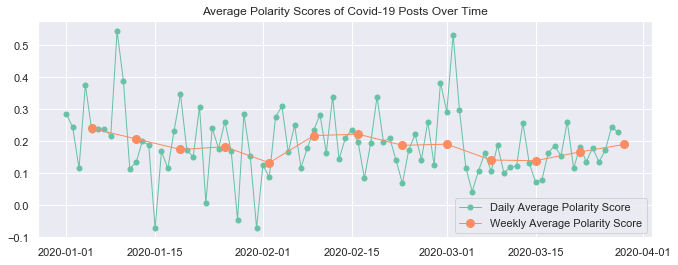

In [515]:
fig, ax = plt.subplots()
#ax.plot(time_covid['polarity_score_compound'].resample('H').mean(), marker='.', linestyle='-', linewidth=0.2)
ax.plot(time_covid['polarity_score_compound'].resample('D').mean(), marker='o', markersize=5, linestyle='-', linewidth=1, label='Daily Average Polarity Score')
ax.plot(time_covid['polarity_score_compound'].resample('W').mean(), marker='o', markersize=8, linestyle='-', linewidth=1, label='Weekly Average Polarity Score')
ax.legend()
ax.set_title('Average Polarity Scores of Covid-19 Posts Over Time');

## Location
In the following section, we will attempt to get the location from which each post was published. Please keep in mind that relatively few posts contain this information.

In [516]:
import json
def get_country(loc):
    if loc is not None:
        try:
            return json.loads(str(loc['address_json']))['country_code']
        except:
            return None
    return None

In [606]:
en_covid_posts.loc[:, 'country'] = en_covid_posts['location'].apply(get_country)
time_covid = en_covid_posts.set_index('timestamp')

### Count Occurence of Key Words Over Time

In [482]:
def count_occurence(caption, word):
    return len(re.findall(word, caption.lower()))

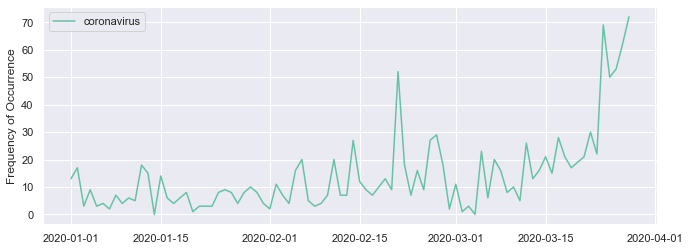

In [632]:
key_words = ['coronavirus']
fig, ax = plt.subplots()
for word in key_words:
    ax.plot(time_covid['caption'].apply(lambda x: count_occurence(x, word)).resample('D').sum(), label=word)
ax.set_ylabel('Frequency of Occurrence')
ax.legend();

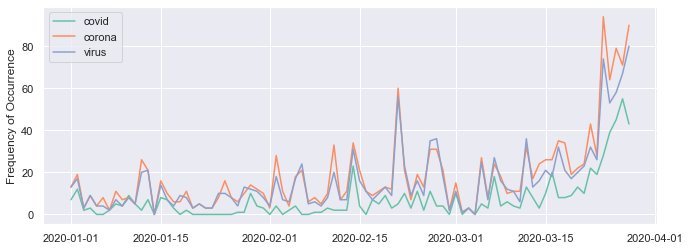

In [618]:
key_words = ['covid', 'corona', 'virus']
fig, ax = plt.subplots()
for word in key_words:
    ax.plot(time_covid['caption'].apply(lambda x: count_occurence(x, word)).resample('D').sum(), label=word)
ax.set_ylabel('Frequency of Occurrence')
ax.legend();

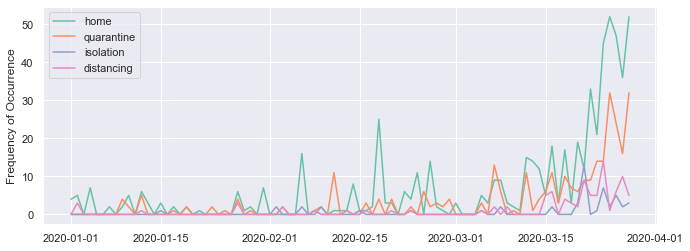

In [622]:
key_words = ['home', 'quarantine', 'isolation', 'distancing']
fig, ax = plt.subplots()
for word in key_words:
    ax.plot(time_covid['caption'].apply(lambda x: count_occurence(x, word)).resample('D').sum(), label=word)
ax.set_ylabel('Frequency of Occurrence')
ax.legend();

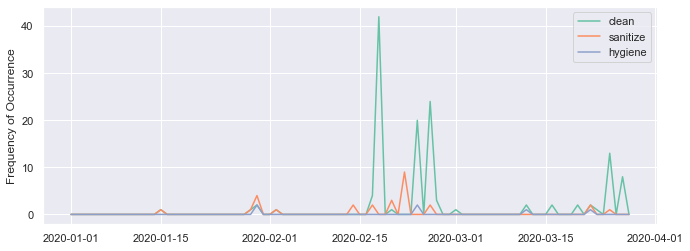

In [624]:
key_words = ['clean', 'sanitize', 'hygiene']
fig, ax = plt.subplots()
for word in key_words:
    ax.plot(time_covid['caption'].apply(lambda x: count_occurence(x, word)).resample('D').sum(), label=word)
ax.set_ylabel('Frequency of Occurrence')
ax.legend();

### Caption Exploration

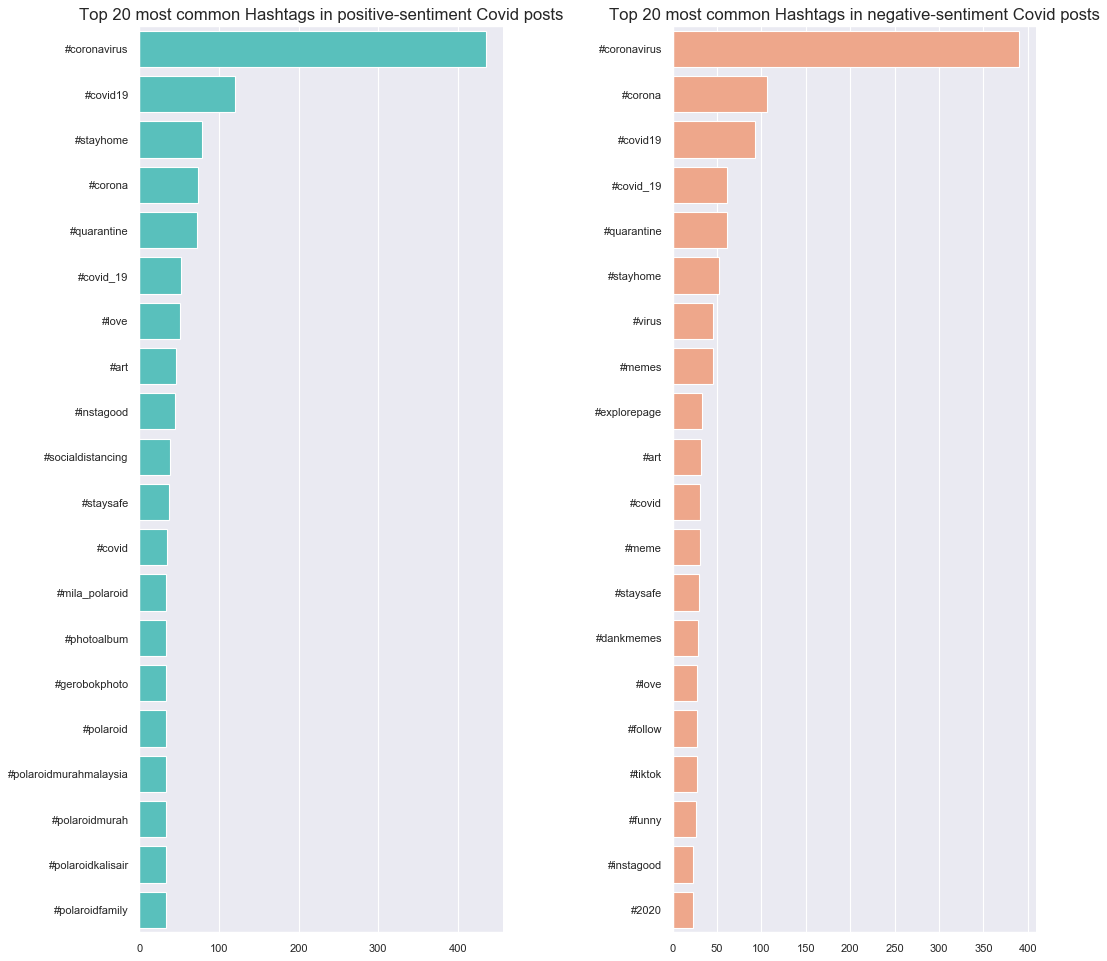

In [642]:
positive_fdist, negative_fdits = get_freq_dists(en_covid_posts, 'hashtags_caption')
plot_freq_dists(positive_fdist, negative_fdits, 'Hashtags', 20)

## Text Exploration Visualizers

### Get key words that identify positive-sentiment posts

In [711]:
en_covid_posts['clean_message'] = en_covid_posts['clean_message'].str.replace('\n', '')
en_covid_posts['positive_sent'] = en_covid_posts['positive_sentimentality'].map({True: 'positive-sentiment', False: 'negative-sentiment'})
corpus = st.CorpusFromPandas(en_covid_posts, category_col='positive_sent', text_col='clean_message', nlp=nlp).build()

term_freq_df = corpus.get_term_freq_df()
term_freq_df['Skeptic Score'] = corpus.get_scaled_f_scores('positive-sentiment')
print('The following words are the most important words to differentiate positive-sentiment posts from negative posts: ', 
      list(term_freq_df.sort_values(by='Skeptic Score', ascending=False).index[:7]))

The following words are the most important words to differentiate positive-sentiment posts from negative posts:  ['help', 'stay safe', 'feel', 'fun', 'moss', 'sea moss', 'buy']


In [712]:
html = st.produce_scattertext_explorer(corpus,
                                       category='positive-sentiment',
                                       category_name='positive-sentiment',
                                       not_category_name='negative-sentiment', 
                                       metadata=en_covid_posts['timestamp'].astype(str))

In [713]:
with open('covid_posts_sentiment_key_words.html', 'w') as f:
    f.write(html)

### Emoji Scores

In [714]:
emoji_corpus = st.CorpusFromParsedDocuments(en_covid_posts,
                                             category_col='positive_sent', feats_from_spacy_doc=st.FeatsFromSpacyDocOnlyEmoji(), parsed_col='caption').build()

In [715]:
html = st.produce_scattertext_explorer(emoji_corpus,
                                       category='positive-sentiment',
                                       category_name='positive-sentiment',
                                       not_category_name='negative-sentiment',
                                       metadata=en_covid_posts['timestamp'].astype(str))    

In [716]:
with open('emoji_covid_posts.html', 'w') as f:
    f.write(html)

### Empath Scores

In [706]:
feat_builder = st.FeatsFromOnlyEmpath()
empath_corpus = st.CorpusFromParsedDocuments(en_covid_posts,
                                             category_col='positive_sent',
                                             feats_from_spacy_doc=feat_builder,
                                             parsed_col='caption').build()


In [709]:
html = st.produce_scattertext_explorer(empath_corpus,
                        category='positive-sentiment',
                        category_name='positive-sentiment',
                        not_category_name='negative-sentiment',
                        width_in_pixels=1000,
                        metadata=en_covid_posts['timestamp'].astype(str),
                        use_non_text_features=True,
                        use_full_doc=True,
                        topic_model_term_lists=feat_builder.get_top_model_term_lists())

In [710]:
with open('covid_posts_empath_topics.html', 'w') as f:
    f.write(html)